In [3]:

import sys
import os
import geopandas as gpd
import plotly.express as px
import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
import pandas as pd
from skimage.io import imread
from st_utils import load_shape_file, vectorize, df_2_gdf
from seg_eval import calculate_tp_fn_fp_from_gdf, calculate_seg_eval_metrics, translate_to_bbox, gdf_flip, calculate_area_bounds
from seg_eval import dapi_mem_mask_annotation, load_cell_boundary_parquet, plot_cell_filtration, plot_cell_transcripts
from constants import PIXEL_TO_UM, sample_color, SAMPLES
from shapely.geometry import box

wd = os.getcwd()
print (f'working directory: {wd}')

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")


working directory: /mnt/disks/store/ist_benchmarking


# Load all cell segmentations

In [4]:
all_seg_filename = f'{wd}/data/all_xenium_merscope_cosmx_segmentation_2024.parquet.gzip'

if os.path.isfile(all_seg_filename):
    print (f'{all_seg_filename} is downloaded.')
    gdf_all = gpd.read_parquet(all_seg_filename)
else:
    for sample in ['2024_cosmx_multitissue_htma', '2024_cosmx_multitissue_tumor2'][:1]:
        folder = f'{wd}/data/{sample}/segmentation_by_fov_parquet'
        if not os.path.exists(folder):
            os.makedirs(folder)

        if sample == '2024_cosmx_multitissue_htma':
            total_fov = 151
            data_dir = f'{wd}/data/cosmx/huan_tma_5724/20240430_BWH_TMA_1/20240430_203348_S1/CellStatsDir'
        else:
            total_fov = 177
            data_dir = f'{wd}/data/cosmx/huan_tma_5724/20240430_BWH_TMA2/20240430_203348_S2/CellStatsDir'

        for fov in range(1,total_fov):
            fov = str(fov).zfill(3)
            filename = f'{data_dir}/FOV{fov}/CellLabels_F{fov}.tif'
            try:
                print (filename)
                img = imread(filename)
                gdf = vectorize(img)
                gdf.to_parquet(f'{folder}/FOV_{fov}.parquet.gzip', compression='gzip')
            except:
                continue

        gdf_all = gpd.GeoDataFrame()

        for sample in SAMPLES:
            if '2024' in sample:
                print (sample)
                gdf = load_cell_boundary_parquet(sample, data_dir=f'{wd}/data')
                gdf['Sample'] = sample
                gdf_all = pd.concat([gdf_all, gdf])

        gdf_all.to_parquet(f'{wd}/data/all_xenium_merscope_cosmx_segmentation_2024.parquet.gzip', compression='gzip', index=False)



/mnt/disks/store/ist_benchmarking/data/all_xenium_merscope_cosmx_segmentation_2024.parquet.gzip is downloaded.


# Calculate segmentation accuracy matrics and plot overlaid figure

In [8]:
data_dir = f'{wd}/data/ground_truth'
plot_dapi = False
plot_filtration = False
plot_transcripts = False
percent = 20
figwidth = 10

metrics_list = []

for core in [99, 147, 165]: # FOV: 71, 30, 8
    for sample in ['2024_xenium_breast_htma','2024_merscope_breast_htma', '2024_cosmx_multitissue_htma']: 
        platform = sample.split('_')[-3]
        print (sample, core)
        ### Get DAPI and membrane (numpy array) and transcripts (geoDataFrame)
        if platform == 'xenium':
            filename_dapi = f'{data_dir}/{core}_{platform}.tif'
            img_dapi = imread(filename_dapi)[...,0]
            img_mem = imread(filename_dapi)[...,1]
            if plot_transcripts:
                gdf_t = gpd.read_parquet(f'{wd}/data/transcript_level_csv/{sample}_transcript_level.parquet.gzip')
                gdf_t = gdf_t.loc[gdf_t['core'] == str(core)]

        elif platform == 'cosmx':
            filename_dapi = f'{data_dir}/{core}_{platform}.jpg'
            filename_mem = f'{data_dir}/{core}_CellComposite.jpg'
            img_dapi = imread(filename_dapi)[...,0]
            img_mem = imread(filename_mem)[...,0]

            if plot_transcripts:
                columns_to_load = ['cell_id','core','x_FOV_px', 'y_FOV_px', 'gene']
                df_t = pd.read_parquet(f'{wd}/data/transcript_level_csv/{sample}_transcript_level.parquet.gzip',
                                    engine='pyarrow', columns=columns_to_load)
                df_t_core = df_t.loc[df_t['core']==str(core)]
                gdf_t= df_2_gdf(df_t_core, 'x_FOV_px','y_FOV_px')

        elif platform == 'merscope':
            filename_dapi = f'{data_dir}/{core}_{platform}.tif'
            filename_mem = f'{wd}/data/{sample}/mem_by_core/{core}.tif'
            img_dapi = imread(filename_dapi)
            img_mem = imread(filename_mem)
            if plot_transcripts:
                gdf_t = gpd.read_parquet(f'{wd}/data/transcript_level_csv/{sample}_transcript_level.parquet.gzip')
                gdf_t = gdf_t.loc[gdf_t['core'] == str(core)]
            
        ### gdf_mask: Segmentation from each platform, geodataframe
        gdf_sample = gdf_all.loc[gdf_all['Sample']==sample]
        gdf_sample['Platform'] = gdf_sample['Sample'].apply(lambda x: x.split("_")[-3].upper())
        ids = np.load(f'{wd}/data/good_cell_ids.npy')

        gdf_sample['Keep'] = gdf_sample['cell_id'].isin(ids).map({True: 1, False: 0})
        if plot_transcripts:
            gdf_t['Keep'] = gdf_t['cell_id'].isin(ids).map({True: 1, False: 0})


        # Get query bounding box
        if platform != 'cosmx':
            if platform == 'xenium':
                bound_box_px_file = f'{wd}/data/{sample}/dapi_by_core/bounding_box_values_px_{core}.npy'
                bound_box_values_px = np.load(bound_box_px_file)
                bound_box_values_um = bound_box_values_px * PIXEL_TO_UM[platform]
            elif platform == 'merscope':
                bound_box_um_file = f'{wd}/data/{sample}/dapi_by_core/bounding_box_values_um_{core}.npy'
                bound_box_values_um = np.load(bound_box_um_file)

            # Using bounding box to query segmentation gdf
            bounding_box = box(*bound_box_values_um)
            queried_gdf = gdf_sample[gdf_sample.intersects(bounding_box)]
            gdf_mask = translate_to_bbox(queried_gdf, bound_box_values_um, img_dapi.shape)
        else:
            gdf_mask = gdf_sample.loc[gdf_sample['core']==str(core)]

        # Flip if necessary
        if platform == 'merscope':
            gdf_mask = gdf_flip(gdf_flip(gdf_mask, direction='lr'), direction='ud')
            gdf_t = gdf_flip(gdf_flip(gdf_t, direction='lr'), direction='ud')

        ### gdf_ground_truth: annotation data in geodataframe format
        shapefile = f'{wd}/data/ground_truth/{core}_{platform}_annotation.shp'
        gdf_gt = load_shape_file(shapefile)

        # Calculate matrics
        tp, fn, fp = calculate_tp_fn_fp_from_gdf(gdf_mask, gdf_gt)
        metrics = calculate_seg_eval_metrics(tp, fn, fp)
        metrics['core'] = core
        metrics['platform'] = platform
        metrics_list.append(metrics)

        if platform == 'cosmx':
            area_bounds = calculate_area_bounds(percent*1.25, img_dapi.shape[0])
            img_dapi = np.flipud(img_dapi)
            gdf_gt = gdf_flip(gdf_gt, direction='ud')
            gdf_mask = gdf_flip(gdf_mask, direction='ud')
            gdf_t = gdf_flip(gdf_t, direction='ud')
        else:
            area_bounds = calculate_area_bounds(percent, img_dapi.shape[0])

        if plot_dapi:
            # plot DAPI + membrane + boundary + annotation    
            scale_bar = ScaleBar(PIXEL_TO_UM[sample.split('_')[-3]], "um", 
                            color='white', box_color='grey', box_alpha=0.9, 
                            location='upper left', font_properties={'size':30})
            dapi_mem_mask_annotation(
                img_dapi, img_mem, gdf_mask, gdf_gt, figwidth, 0.95, 0.99, 
                scale_bar, xy_range=True, area_bounds=area_bounds, lw=1.5, markersize=0.05, 
                boundary_color='white', gt_color='red',
                save=True, fname=f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4_A_{core}_{platform}.png')
            
        if plot_filtration:
            # plot cell filtration 
            scale_bar = ScaleBar(PIXEL_TO_UM[sample.split('_')[-3]], "um", 
                            color='white', box_color='grey', box_alpha=0.9, 
                            location='upper left', font_properties={'size':30})
            plot_cell_filtration(
                    gdf_mask, figwidth, scale_bar,
                    xy_range=True, area_bounds=area_bounds,
                    markersize=1, save=True, fname=f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4_A_keep_drop_{core}_{sample}.png')

        if plot_transcripts:
            # plot all transcripts and specific gene
            scale_bar = ScaleBar(PIXEL_TO_UM[sample.split('_')[-3]], "um", 
                            color='white', box_color='grey', box_alpha=0.9, 
                            location='upper left', font_properties={'size':30})
            for gene in ['EPCAM']:
                plot_cell_transcripts(
                    gdf_t, gene, figwidth, scale_bar,
                    xy_range=False, area_bounds={},
                    markersize=2, only_keep=False, save=True, fname=f'{wd}/figures/Fig_4_Segmentation/Main_Fig_4_A_{gene}_{core}_{sample}.png')
                
# Convert the list of dictionaries to a DataFrame
df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics.sort_values(by=['core','precision'])
df_metrics.to_csv(f'{wd}/data/single_cell_metrics/segmentation_eval_results.csv', index=False)




2024_xenium_breast_htma 99
2024_merscope_breast_htma 99
2024_cosmx_multitissue_htma 99
2024_xenium_breast_htma 147
2024_merscope_breast_htma 147
2024_cosmx_multitissue_htma 147
2024_xenium_breast_htma 165
2024_merscope_breast_htma 165
2024_cosmx_multitissue_htma 165


# Segmentation evaluation

In [10]:
# Display the resulting DataFrame

df_metrics = pd.read_csv(f'{wd}/data/single_cell_metrics/segmentation_eval_results.csv')
core_to_desc = {99:'Sparse cells',147:'Elongated cells', 165:'Dense cells'}
df_metrics['core'] = df_metrics['core'].apply(lambda x: core_to_desc[x])
df_metrics = pd.melt(df_metrics, id_vars=['core', 'platform'], value_vars=['precision','f1_score', 'iou'], 
                    var_name='metric', value_name='value')
df_metrics['metric'] = df_metrics['metric'].apply(
    lambda x: {'precision': 'Precision', 'recall': 'Recall', 'f1_score': 'F1 Score', 'iou': 'IOU'}[x])
display(df_metrics)

custom_palette = {}
for platform in df_metrics['platform'].unique():
    custom_palette[platform] = sample_color[platform]

fontsize=15
width = 1000
height = 400

# Plot using Plotly Express
fig = px.bar(df_metrics, x='metric', y='value',
             barmode='group', facet_col='core', color='platform',
             color_discrete_map=custom_palette,
             width=width, height=height,
             labels={'value': 'Metric Value', 'core': ''})  # Removing label for 'core'

# Update layout and axis properties globally
fig.update_layout(
    xaxis_title='',  # Removing x-axis titles globally
    yaxis_title='Metric Value',
    font=dict(size=fontsize,
              color='black'),
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    legend=dict(
        title='Platform',
        orientation="h",  # horizontal alignment
        yanchor="bottom", 
        y=1.05,  # position legend just above the plot
        xanchor="right",
        x=0.99  # center the legend
        ),
)

# Update axes to show lines, applicable to all axes
fig.update_xaxes(matches='x', showline=True, linewidth=1, linecolor='black', title='')
fig.update_yaxes(matches='y', showline=True, linewidth=1, linecolor='black', range=[0, 1])


# Update facet titles

for annotation in fig.layout.annotations:
    annotation.y -= 0.05
    text = annotation.text.split('=')[-1]  # Get the value after 'metric='
    annotation.text = text

fig.show()
pio.write_image(fig, f'{wd}/figures/Fig_4_Segmentation/evaluation.png',scale=4, width=width, height=height)



,core,platform,metric,value
0,Sparse cells,merscope,Precision,0.556528
1,Sparse cells,cosmx,Precision,0.732155
2,Sparse cells,xenium,Precision,0.734509
3,Elongated cells,merscope,Precision,0.791987
4,Elongated cells,cosmx,Precision,0.838904
5,Elongated cells,xenium,Precision,0.842664
6,Dense cells,merscope,Precision,0.832433
7,Dense cells,xenium,Precision,0.901997
8,Dense cells,cosmx,Precision,0.916880
9,Sparse cells,merscope,F1 Score,0.713693


# Generate legend for the whole figure

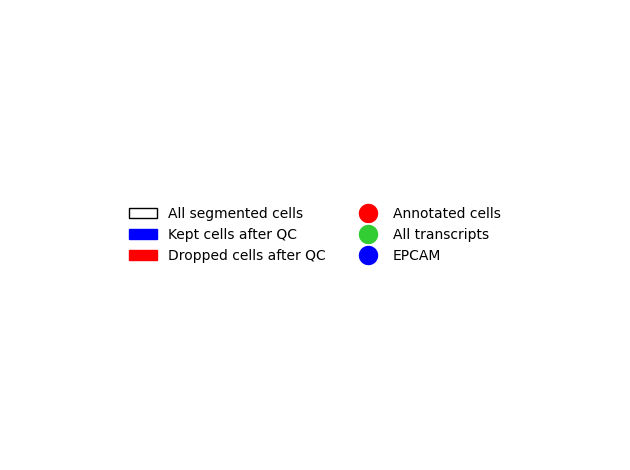

In [11]:
gene = 'EPCAM'

legend_elements = [Patch(facecolor='none', edgecolor='black', label='All segmented cells'),
                   Patch(facecolor='Blue', edgecolor='Blue', label='Kept cells after QC'),
                   Patch(facecolor='Red', edgecolor='Red', label='Dropped cells after QC'),
                   Line2D([0], [0], marker='o', color='w', label='Annotated cells', markerfacecolor='red', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label='All transcripts', markerfacecolor='limegreen', markersize=15),
                   Line2D([0], [0], marker='o', color='w', label=f'{gene}', markerfacecolor='blue', markersize=15),]

# Create the figure
fig, ax = plt.subplots()
legend = ax.legend(handles=legend_elements, loc='center', ncol=2)  # Set ncol to 3 for three columns

# Hide the frame of the legend
legend.set_frame_on(False)

plt.axis('off')
plt.tight_layout()
plt.show()
fig.savefig('figures/segmentation_legend.png', format='png', dpi=500, transparent=True)
fig.savefig('figures/segmentation_legend.eps', format='eps', dpi=500, transparent=True)


In [ ]:
# fov = 9
# fov = str(fov).zfill(3)
# data_dir = f'data/cosmx/huan_tma_5724/20240430_BWH_TMA_1/20240430_203348_S1/CellStatsDir'
# for filename_mem in [
#     f'{data_dir}/CellComposite/CellComposite_F{fov}.jpg']:
#     im_mem = imread(filename_mem)
#     if im_mem.ndim ==3:
#         for i in range(im_mem.shape[-1]):
#             print (filename_mem, '----- band',i)
#             imshow(im_mem[2000:2500, 2000:2500,i], resize=False, vlim=False)
#             print (f'unique values:{np.unique(im_mem)}')
#     else:
#         print (filename_mem, '----- 0')
#         imshow(im_mem[2000:2500, 2000:2500], resize=False)